In [2]:
library(geosphere)
library(parallel)
library(ggplot2)
library(Matrix)
library(dplyr)
library(lubridate)
library(ggsci)
library(viridis)

In [3]:
homere = feather::read_feather("homere")
predictor = readRDS("data_prep")

In [4]:
travel_time_max = 90
temporal_width_max = 15

## local model

In [5]:
w = sqrt(homere$uwnd^2+homere$vwnd^2)
f = homere$fetch
indices = (travel_time_max+1):length(w)
ind = indices[(temporal_width_max+1):(length(indices)-temporal_width_max)]
homere = homere[ind,]
local = cbind(w[ind],w[ind]^2,w[ind]^3,f[ind]*w[ind]^2,w[ind-1],w[ind-1]^2,w[ind-1]^3,f[ind-1]*w[ind-1]^2)
train = 1:58340
test = 58341:nrow(local)
y_train = homere[train,]
y_test = homere[test,]
l_train = local[train,]
l_test = local[test,]
dates = seq(as.POSIXct("1994-01-01 0:00"),as.POSIXct("2016-12-31 23:00"), by="hour")
id = seq(1,length(dates),3)
dates = dates[id]
dates = dates[ind]
dates_train = dates[train]
dates_test = dates[test]

In [6]:
l_model = lm(y_train$hs~l_train)
pred = l_test%*%l_model$coefficients[-1]+l_model$coefficients[1]
fitted = l_model$fitted.values

In [7]:
rmse = function(o, p){
    return(sqrt(mean((o-p)^2)))
}
bias = function(o,p ){
    return(mean(o-p))
}
df1 = data.frame(hs = y_test$hs, pred = pred)
p1 = ggplot(df1) + geom_point(aes(x = hs,y = pred))+
  geom_abline(slope = 1,intercept = 0)+xlab("observed")+
  ylab("predicted")+
  geom_text(data=tibble(x = 0.4, y = 8.5),aes(x=x , y=y ,label=paste0("r = ",round(cor(df1$hs,df1$pred),digits = 3), "\n","RMSE = ",round(rmse(df1$hs,df1$pred),digits = 3),"\n",
                                                                      "Bias = ",round(bias(df1$hs,df1$pred),digits = 3))
                                                                     , hjust=0))+
  xlim(0.1, max(y_train$hs)) + ylim(0.1, max(y_train$hs)) + theme_minimal()+theme(aspect.ratio=0.9, plot.title = element_text(size = 9, hjust = 0.5))+
  ggtitle("validation period")
df = data.frame(hs = y_train$hs, pred = fitted)
p2 = ggplot(df) + geom_point(aes(x = hs,y = pred))+
  geom_abline(slope = 1,intercept = 0)+xlab("observed")+
  ylab("predicted")+
  geom_text(data=tibble(x = 0.4, y = 8.5),aes(x=x , y=y ,label=paste0("r = ",round(cor(df$hs,df$pred),digits = 3), "\n","RMSE = ",round(rmse(df$hs,df$pred),digits = 3),"\n",
                                                                      "Bias = ",round(bias(df$hs,df$pred),digits = 3))
                                                                     , hjust=0))+
  xlim(0.1, max(y_train$hs)) + ylim(0.1, max(y_train$hs)) + theme_minimal()+theme(aspect.ratio=0.9, plot.title = element_text(size = 9, hjust = 0.5))+
  ggtitle("calibration period")

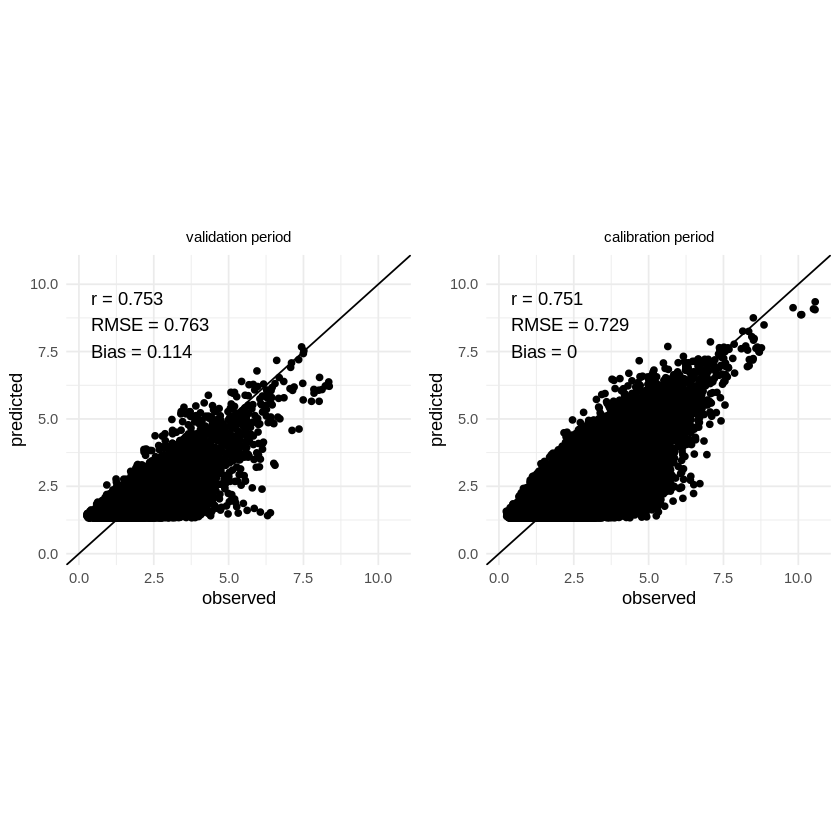

In [8]:
gridExtra::grid.arrange(p1,p2, ncol = 2)

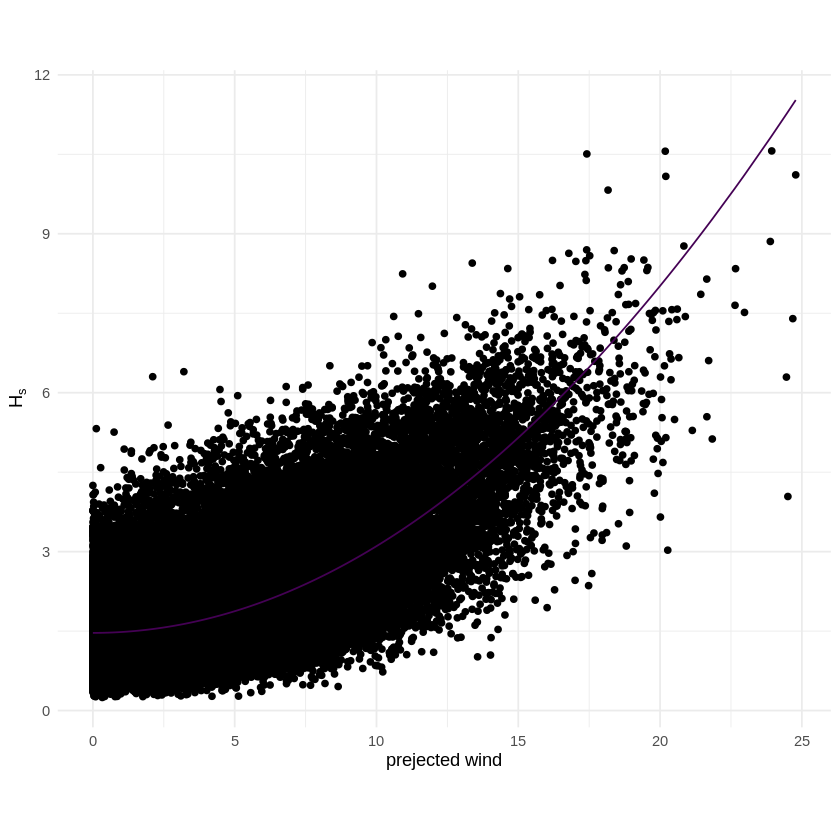

In [9]:
homere = feather::read_feather("homere")
pw = predictor$pw
cr = cor(homere$hs,pw)
vir = viridis_pal()(10)
pwj = pw[,which.max(cr)]^2
mod = lm(homere$hs~pwj)
df = data.frame(pwj = pw[,which.max(cr)],Hs = homere$hs, fitted = mod$fitted.values)
ggplot(df, aes(x = pwj, y= Hs))+ geom_point() + geom_line(aes(y=fitted),color=vir[1], show.legend = FALSE) + xlab("prejected wind") +
  theme_minimal() + ylab(bquote(H[s]))+theme(aspect.ratio=0.85)

In [10]:
lonlat = predictor$lonlat

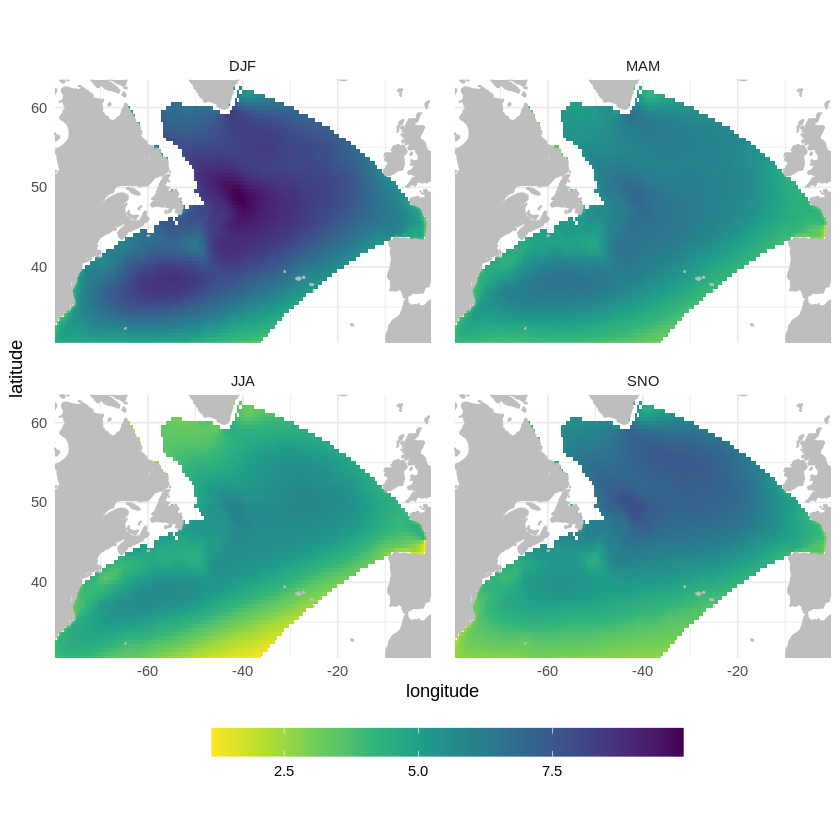

In [11]:
dates = seq(as.POSIXct("1994-01-01 0:00"),as.POSIXct("2016-12-31 23:00"), by="hour")
id = seq(1,length(dates),3)
dates = dates[id]
months = month(dates)
months[months == 12| months ==1 | months == 2]  = "DJF"
months[months == 3| months ==4 | months == 5]  = "MAM"
months[months == 6| months ==7 | months == 8]  = "JJA"
months[months == 9| months ==10 | months == 11]  = "SNO"
df1 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = apply(pw[months == "DJF",],2, mean), season = "DJF")
df2 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = apply(pw[months == "MAM",],2, mean), season = "MAM")
df3 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = apply(pw[months == "JJA",],2, mean), season = "JJA")
df4 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = apply(pw[months == "SNO",],2, mean), season = "SNO")
df = rbind(df1, df2, df3, df4)
ggplot(df) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn("" ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+
 borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-76, -4), ylim = c(32, 62)) + facet_wrap(~season)+
theme(legend.position = "bottom", legend.key.width = unit(2, 'cm'))

In [12]:
rm(pw)

## Travel time of waves and temporal width

In [13]:
travel_time_max = 90
temporal_width_max = 15

In [14]:
tw = predictor$alpha
tt = predictor$travel_time

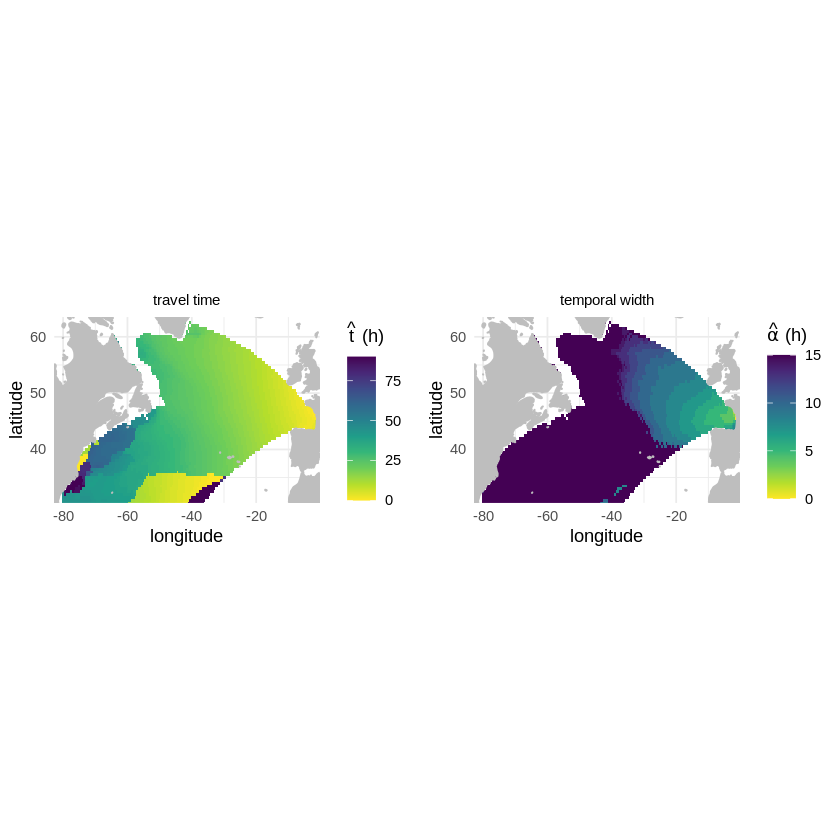

In [15]:
df1 = data.frame(long = lonlat[,1], lat = lonlat[,2], x = tt)
df2 = data.frame(long = lonlat[,1], lat = lonlat[,2], x = tw)
p1 = ggplot(df1) + geom_tile(aes(long, lat, fill = x))+scale_fill_gradientn(bquote(hat(t)~"(h)") ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+ggtitle("travel time")+
 borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p2 = ggplot(df2) + geom_tile(aes(long, lat, fill = x))+scale_fill_gradientn(bquote(hat(alpha)~"(h)") ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5),panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+ggtitle("temporal width")+
 borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
gridExtra::grid.arrange(p1, p2, ncol = 2)

### Travel time example 

In [12]:
di = sapply(1:nrow(lonlat), function(i) distm(c(lonlat[i,1],lonlat[i,2]),c(-1.608805,45.255269),fun=distHaversine))

In [7]:
point = 1513
sprintf("longitude:  %f", lonlat[point,1])
sprintf("latitude:  %f", lonlat[point,2])

[1] "longitude:  -70.500000"

[1] "latitude:  38.000000"

In [8]:
d=di[point]/1000 #distance in km
t= tt[point]*3  
vmean=d/t/3.6 
Tmean=4*pi*vmean/9.81
alpha=tw[5283]*3
vmin=d/(t-alpha)/3.6
Tmax=4*pi*vmin/9.81 
vmax=d/(t+alpha)/3.6 
Tmin=4*pi*vmax/9.81
sprintf("Min period is: %f,  mean period is: %f, and max period is: %f",Tmin,  Tmean, Tmax)
sprintf("Min vitesse is: %f,  mean vitesse is: %f, and max vitesse is: %f",vmax,  vmean, vmin)

[1] "Min period is: 9.377773,  mean period is: 11.097031, and max period is: 13.588202"

[1] "Min vitesse is: 7.320805,  mean vitesse is: 8.662953, and max vitesse is: 10.607697"

## Wind-waves model 

### Global predictor

In [16]:
global = predictor$predictor
rm(predictor)

In [17]:
w = sqrt(homere$uwnd^2+homere$vwnd^2)
f = homere$fetch
indices = (travel_time_max+1):length(w)
ind = indices[(temporal_width_max+1):(length(indices)-temporal_width_max)]
homere = homere[ind,]
local = cbind(w[ind],w[ind]^2,w[ind]^3,f[ind]*w[ind]^2,w[ind-1],w[ind-1]^2,w[ind-1]^3,f[ind-1]*w[ind-1]^2)

### Homere sea states

In [18]:
number_of_sea_states = 2
homere$sea_state = "swell"
homere$sea_state[is.na(homere[,2])&is.na(homere[,3])&is.na(homere[,4])&is.na(homere[,5])&is.na(homere[,6])] = "wind sea"

In [19]:
train = 1:58340
test = 58341:nrow(local)
y_train = homere[train,]
y_test = homere[test,]
g_train = global[train,]
g_test = global[test,]
l_train = local[train,]
l_test = local[test,]

In [20]:
rm(global)

In [21]:
dates = seq(as.POSIXct("1994-01-01 0:00"),as.POSIXct("2016-12-31 23:00"), by="hour")
id = seq(1,length(dates),3)
dates = dates[id]
dates = dates[ind]
dates_train = dates[train]
dates_test = dates[test]

### Predictors scaling 

In [22]:
sg = sapply(1:ncol(g_train), function(i) sd(g_train[,i]))
sl = sapply(1:ncol(l_train), function(i) sd(l_train[,i]))
g_train = scale(g_train, center = F, scale = sg)
l_train = scale(l_train, center = F, scale = sl)
g_test = scale(g_test, center = F, scale = sg)
l_test = scale(l_test, center = F, scale = sl)

### Cross-validation

In [23]:
#### ridge function
ridge = function(y,fixed=NULL,lambda ,sv) {
    d = sv$d^2/(sv$d^2+lambda)
    u = t(fixed)%*%sv$u
    u = t(t(u)*d)%*%t(sv$u)
    beta_l = corpcor::pseudoinverse(crossprod(fixed) - u%*%fixed)%*%(t(fixed)-u)%*%y
    v = crossprod(sv$u,(y-(fixed%*%beta_l)))
    beta_g = crossprod((d/sv$d )*t(sv$v),v) 
    return(list(beta_l=beta_l,beta_g=beta_g))
}
minWeightBipartiteMatching <- function(clusteringA, clusteringB) {
  require(clue)
  idsA <- unique(clusteringA)  # distinct cluster ids in a
  idsB <- unique(clusteringB)  # distinct cluster ids in b
  nA <- length(clusteringA)  # number of instances in a
  nB <- length(clusteringB)  # number of instances in b
  if (length(idsA) != length(idsB) || nA != nB) {
    stop("number of cluster or number of instances do not match")
  }
  nC <- length(idsA)
  tupel <- c(1:nA)
  # computing the distance matrix
  assignmentMatrix <- matrix(rep(-1, nC * nC), nrow = nC)
  for (i in 1:nC) {
    tupelClusterI <- tupel[clusteringA == idsA[i]]
    solRowI <- sapply(1:nC, function(i, clusterIDsB, tupelA_I) {
      nA_I <- length(tupelA_I)  # number of elements in cluster I
      tupelB_I <- tupel[clusterIDsB == i]
      nB_I <- length(tupelB_I)
      nTupelIntersect <- length(intersect(tupelA_I, tupelB_I))
      return((nA_I - nTupelIntersect) + (nB_I - nTupelIntersect))
    }, clusteringB, tupelClusterI)
    assignmentMatrix[i, ] <- solRowI
  }
  # optimization
  result <- solve_LSAP(assignmentMatrix, maximum = FALSE)
  attr(result, "assignmentMatrix") <- assignmentMatrix
  return(result)
}
clusters = function(x, centers) {
                  tmp = sapply(seq_len(nrow(x)),
                                function(i) apply(centers, 1,
                                        function(v) sum((x[i, ]-v)^2)))
                max.col(-t(tmp))  
}

In [29]:
lambda = exp(seq(1, 16, 0.8))
nfolds = 5
folds = lapply(0:(nfolds-1), function(i) return((i*floor(nrow(g_train)/nfolds))+(1:floor(nrow(g_train)/nfolds))))
cv = lapply(1:nfolds, function(k){
    g_train_f = g_train[-folds[[k]],]
    l_train_f = l_train[-folds[[k]],]
    y_train_f = y_train[-folds[[k]],]
    g_test_f = g_train[folds[[k]],]
    l_test_f = l_train[folds[[k]],]
    y_test_f = y_train[folds[[k]],]    
    svd = svd(g_train_f)      
    hm = mclapply(lambda,mc.cores = 2, function(l){
       require(ClusterR)
       g = ridge(y=y_train_f$hs, fixed = l_train_f, lambda=l, sv=svd)
       xbg = sapply(1:ncol(g_train_f), function(i) g_train_f[,i]*g$beta_g[i] )
       xbl = sapply(1:ncol(l_train_f), function(i) l_train_f[,i]*g$beta_l[i] )
       xb = cbind(xbl, xbg)
       rm(svd); rm(g_train_f); gc()                          
       km = kmeans(xb, number_of_sea_states)
       xbgt = sapply(1:ncol(g_train_f), function(i) g_test_f[,i]*g$beta_g[i] )
       xblt = sapply(1:ncol(l_train_f), function(i) l_test_f[,i]*g$beta_l[i] )
       xbt = cbind(xblt, xbgt)
       cluster = clusters(xbt, km$centers)
       cl = unique(y_test_f$sea_state)
       attr = c(minWeightBipartiteMatching(y_test_f$sea_state, cluster))
       for(i in 1:length(cl)){
           cluster[cluster==attr[i]] = cl[i]
       }             
       tab = table(y_test_f$sea_state, cluster)
       acc = max(sum(diag(tab))/sum(tab),sum(diag(t(tab)))/sum(tab))             
       mi = infotheo::mutinformation(cluster, y_test_f$sea_state)               
       pred = g_test_f%*%g$beta_g+ l_test_f%*%g$beta_l
       cr = cor(y_test_f$hs, pred)
       rmse = sqrt(mean((y_test_f$hs-pred)^2))
       gc() 
       return(c(acc,mi, rmse))
   }) 
   return(hm)     
})

In [43]:
cv = lapply(1:length(cv),function(i) t(matrix(unlist(cv[[i]]), nrow = 3)))

In [24]:
#saveRDS(cv, paste0("cv_",number_of_sea_states,"_states"))          

In [24]:
cv = readRDS(paste0("cv_",number_of_sea_states,"_states"))

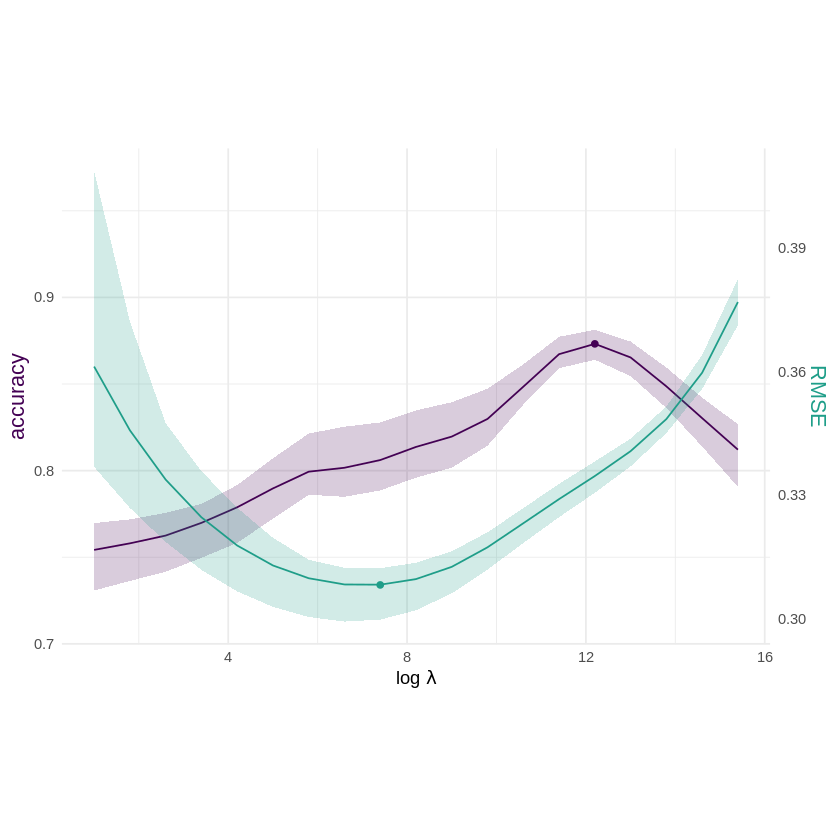

In [25]:
lambda = exp(seq(1, 16, 0.8))
mcv = (1/5)*(cv[[1]]+cv[[2]]+cv[[3]]+cv[[4]]+cv[[5]])
acc = cbind(cv[[1]][,1],cv[[2]][,1],cv[[3]][,1],cv[[4]][,1],cv[[5]][,1])
rmse = cbind(cv[[1]][,3],cv[[2]][,3],cv[[3]][,3],cv[[4]][,3],cv[[5]][,3])
sacc = apply(acc, 1, sd)
srmse = apply(rmse, 1, sd)
minacc = apply(acc, 1, min)
minrmse = apply(rmse, 1, min)
maxacc = apply(acc, 1, max)
maxrmse = apply(rmse, 1, max)
library(viridis)
vir = viridis_pal()(10)
df = data.frame(accuracy = mcv[,1], lambda = log(lambda), rmse = mcv[,3],
                CI_lower_a = mcv[,1] - sacc, CI_upper_a = mcv[,1] + sacc,
                CI_lower_r = mcv[,3] - srmse, CI_upper_r = mcv[,3] + srmse,
               minacc = minacc, minrmse = minrmse, maxacc= maxacc, maxrmse = maxrmse)
x1 = log(lambda[which.max(mcv[,1])]); y1 = mcv[which.max(mcv[,1]),1]
x2 = log(lambda[which.min(mcv[,3])]); y2 = mcv[which.min(mcv[,3]),1]
      
ggplot(df, aes(x = lambda)) + geom_line(aes(y = accuracy), color = vir[1])+geom_ribbon(aes(ymin=minacc, ymax=maxacc), fill=vir[1], alpha=0.2)+
annotate("point", x = x1, y = y1, colour = vir[1])+annotate("point", x = x2, y = 0.734, colour = vir[6])+
    geom_line(aes(y = rmse/0.42), color = vir[6])+geom_ribbon(aes(ymin=minrmse/0.42, ymax=maxrmse/0.42), fill=vir[6], alpha=0.2)+
     scale_y_continuous(
    name = "accuracy",sec.axis = sec_axis(~.*0.42, name="RMSE"))+ theme_minimal()+ xlab(bquote("log"~lambda))+
    theme(aspect.ratio=0.7, axis.title.y = element_text(color = vir[1], size=13), axis.title.y.right = element_text(color = vir[6], size=13))

In [26]:
svd = svd(g_train)

In [27]:
g = ridge(y=y_train$hs, fixed = l_train, lambda=lambda[which.max(mcv[,1])], sv=svd)
g1 = ridge(y=y_train$hs, fixed = l_train, lambda=lambda[which.min(mcv[,3])], sv=svd)

In [29]:
rmse = function(o, p){
    return(sqrt(mean((o-p)^2)))
}
bias = function(o,p ){
    return(mean(o-p))
}
pred = g_test%*%g$beta_g + l_test%*%g$beta_l
pred1 = g_test%*%g1$beta_g + l_test%*%g1$beta_l
rmse(y_test$hs, pred)
rmse(y_test$hs, pred1)

[1] 0.35017

[1] 0.3216064

In [30]:
xbg = sapply(1:ncol(g_train), function(i) g_train[,i]*g$beta_g[i] )
xbgt = sapply(1:ncol(g_train), function(i) g_test[,i]*g$beta_g[i] )
xbg1 = sapply(1:ncol(g_train), function(i) g_train[,i]*g1$beta_g[i] )
xbgt1 = sapply(1:ncol(g_train), function(i) g_test[,i]*g1$beta_g[i] )              

In [31]:
set.seed(1)
km = kmeans(xbg, number_of_sea_states)
km1 = kmeans(xbg1, number_of_sea_states)

In [32]:
clu_pred = clusters(xbgt, km$centers)
clu_pred_1 = clusters(xbgt1, km1$centers)
tab = table(y_test$sea_state, clu_pred)
tab1 = table(y_test$sea_state, clu_pred_1)

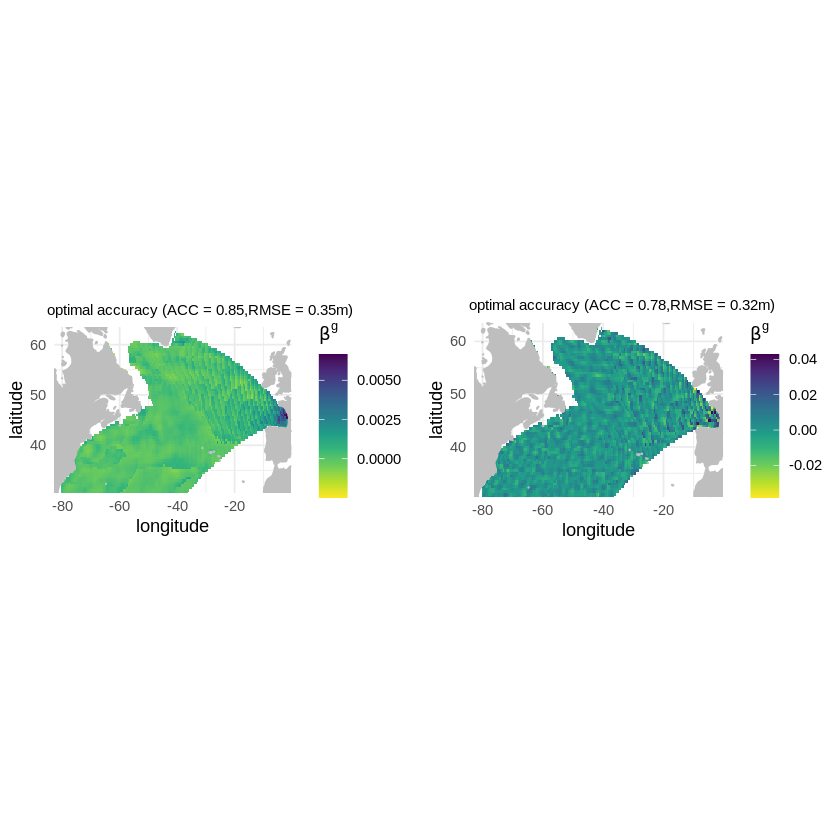

In [33]:
df1 = data.frame(long = lonlat[,1], lat = lonlat[,2], x = g$beta_g, nao = "optimal RMSE")
df2 = data.frame(long = lonlat[,1], lat = lonlat[,2], x = g1$beta_g, nao = "optimal RMSE")
p1 = ggplot(df1) + geom_tile(aes(long, lat, fill = x))+scale_fill_gradientn(bquote(beta^g) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.1), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+
ggtitle(paste0("optimal accuracy (ACC = ",round(sum(diag(tab))/sum(tab),2), ",", "RMSE = ",round(rmse(y_test$hs, pred),2),"m)"))+
 borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p2 = ggplot(df2) + geom_tile(aes(long, lat, fill = x))+scale_fill_gradientn(bquote(beta^g) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.1),panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+
ggtitle(paste0("optimal accuracy (ACC = ",round(sum(diag(tab1))/sum(tab1),2), ",", "RMSE = ",round(rmse(y_test$hs, pred1),2),"m)"))+
 borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
gridExtra::grid.arrange(p1, p2, ncol = 2)

In [34]:
rm(km1)
rm(xbg1)
rm(xbgt1)

In [35]:
clu = c(km$cluster)
tab = table(y_train$sea_state, clu)
tab

          clu
               1     2
  swell    47074  6388
  wind sea   974  3904

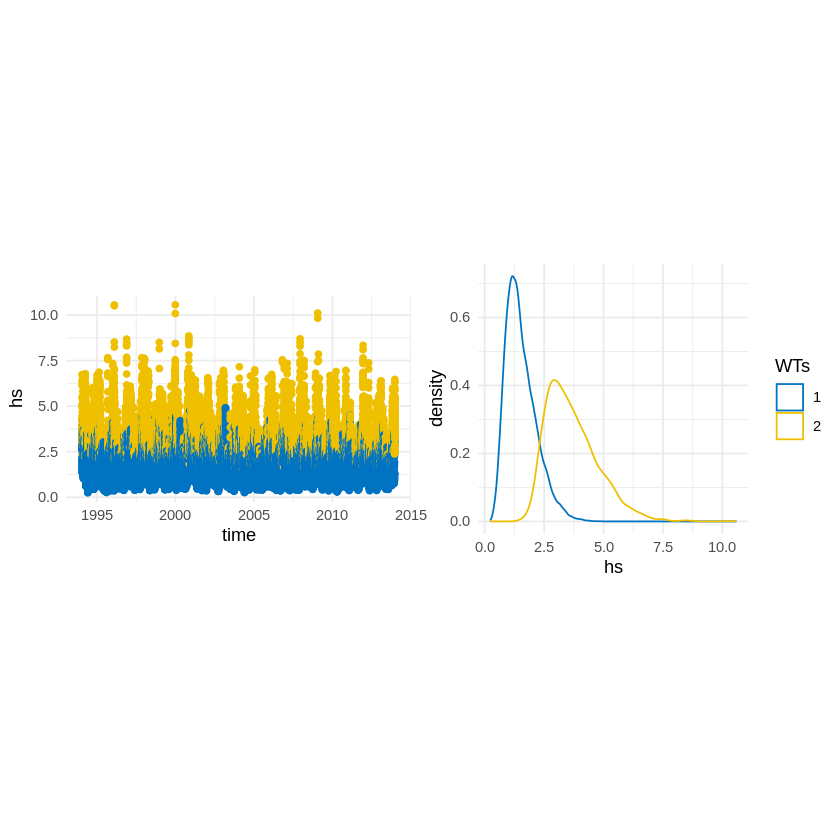

In [36]:
df = data.frame(time = dates_train,dir=y_train$dp, fp = y_train$fp,  hs = y_train$hs, grp = as.character(clu))
p1 = ggplot(df) + geom_point(aes(x = time, y = hs, color = grp)) + theme_minimal() + theme(legend.position = "none",aspect.ratio=0.6)+scale_color_jco()
p2 = ggplot(df, aes(x=hs)) + geom_density(aes(colour=grp),alpha = 0.1)+ theme_minimal()+scale_color_jco(name = "WTs")+ theme(aspect.ratio=1)
gridExtra::grid.arrange(p1, p2, ncol = 2)

In [37]:
mn = colMeans(xbg)
p = vector("list", number_of_sea_states)
for(i in 1:number_of_sea_states){
    xbi = colMeans(xbg[km$cluster==i,]) - mn
    df = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xbi)
    lg = bquote(x[beta^g]~"(" ~ .(i)~")")
    pi = ggplot(df) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(lg ,colours = rev(viridis(10)))+theme_minimal()+
    theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("latitude")+ggtitle(as.character(i))+
    borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
    p[[i]] = pi
}

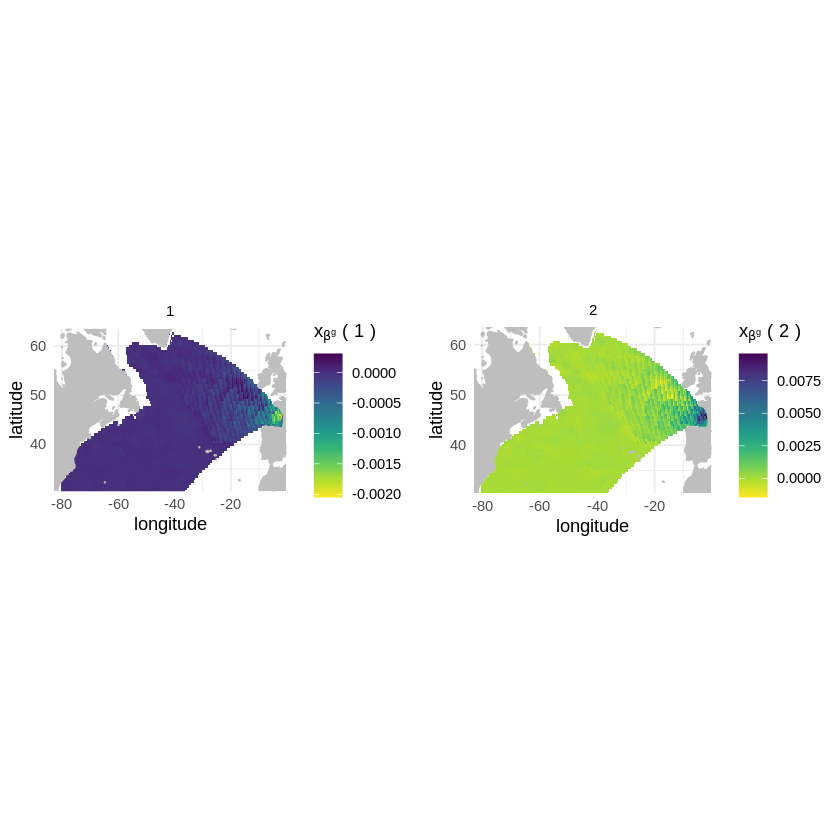

In [38]:
gridExtra::grid.arrange(p[[1]],p[[2]], ncol = number_of_sea_states)

In [41]:
WT_reg = function(x,y,p,cluster,k, lambda, lam){
    cl = sort(unique(cluster))
    m = mclapply(1:k,mc.cores = k,function(i){
        x_tr = x[cluster == cl[i],]
        p_tr = p[cluster == cl[i],]
        s= sapply(1:ncol(x_tr), function(i){sd(x_tr[,i])})
        sl = sapply(1:ncol(p_tr), function(i){sd(p_tr[,i])})                 
        m = sapply(1:ncol(x_tr), function(i){mean(x_tr[,i])})
        ml = sapply(1:ncol(p_tr), function(i){mean(p_tr[,i])}) 
        x_tr = scale(x_tr, scale = s, center = m)
        p_tr = scale(p_tr, scale = sl, center = ml)
        n = nrow(x_tr)
        svdk = svd(x_tr)
        gk = ridge(y=y[cluster == cl[i]],fixed = p_tr,lambda=lambda,sv=svdk)
        beta_g = gk$beta_g
        beta_l = gk$beta_l
        my = mean(y[cluster == cl[i]])
        return(list(beta_l = beta_l, beta_g = beta_g, s = s, sl = sl, m = m ,ml = ml, my = my))                      
    })
    return(m)
}
clusters = function(x, centers) {
                  tmp = sapply(seq_len(nrow(x)),
                                function(i) apply(centers, 1,
                                        function(v) sum((x[i, ]-v)^2)))
                max.col(-t(tmp))  
}
WT_pred = function(b, x_test, p_test,cluster,k){
    cl = sort(unique(cluster))
    pred = numeric(nrow(x_test))
    for(i in 1:k){
             x_t = x_test[cluster == i,]
             p_t = p_test[cluster == i,]
             x_t = scale(x_t, scale =b[[i]]$s, center = b[[i]]$m)
             p_t = scale(p_t, scale = b[[i]]$sl, center = b[[i]]$ml)
             pred[cluster == i] = x_t%*%b[[i]]$beta_g+ p_t%*%b[[i]]$beta_l + b[[i]]$my
    }
    return(pred)
}

In [47]:
cv = sapply(1:8, function(k){
   if(k==1){
       pred = g_test%*%g$beta_g+ l_test%*%g$beta_l 
       return(sqrt(mean((y_test$hs-pred)^2)))
   }
   km = kmeans(xbg, k)
   clu = as.vector(km$cluster) 
   b = WT_reg(g_train, y_train$hs, l_train,clu, k, lambda = 1.1e+3)
   cluster = clusters(xbgt, km$centers)
   pred = WT_pred(b,g_test, l_test,cluster, k)
   return(sqrt(mean((y_test$hs-pred)^2)))
})

In [49]:
#saveRDS(cv,"cv_wt")

In [42]:
cv = readRDS("cv_wt")

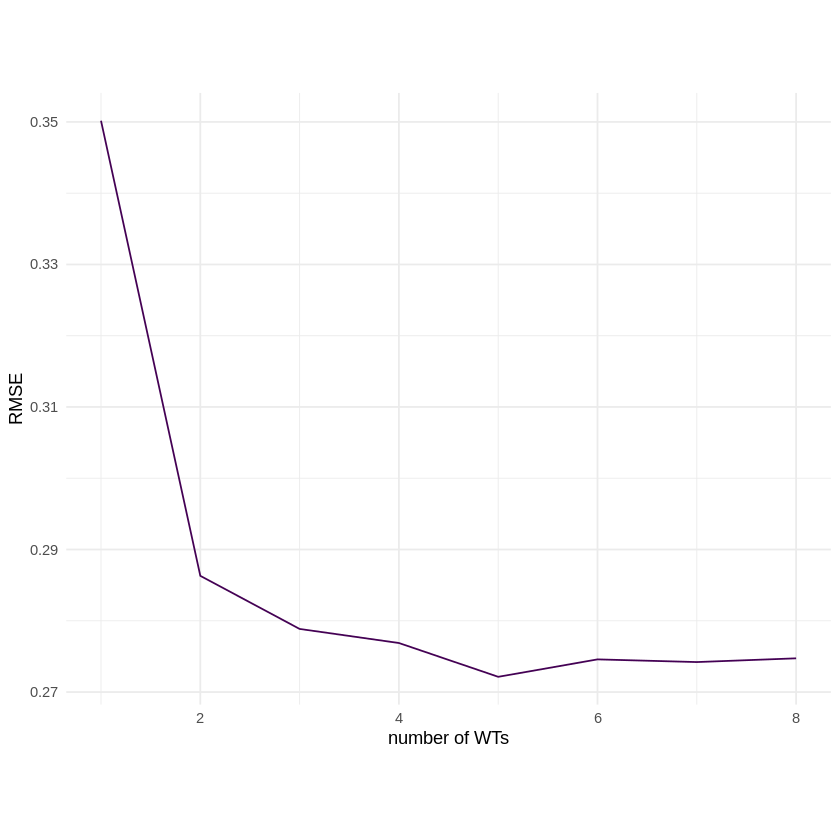

In [43]:
df = data.frame(rmse = cv, wt = 1:8)
vir = viridis_pal()(10)
ggplot(df, aes(x = wt, y = rmse)) + geom_line(color = vir[1])+ theme_minimal()+xlab("number of WTs")+ ylab("RMSE")+theme(aspect.ratio=0.8)

In [44]:
which.min(cv)

[1] 5

In [45]:
rm(svd)

In [46]:
k = 5
set.seed(10)
km = kmeans(xbg, k)

In [47]:
clu_train = as.vector(km$cluster)
clu_test = clusters(xbgt, km$centers)

In [48]:
fr = sapply(1:k, function(k){
    (length(which(clu_train==k))/length(clu_train))*100
})
classes_train = c()
classes_test = c()
for(i in 1:k){
    classes_train[clu_train==order(fr, decreasing=T)[i]] = i 
    classes_test[clu_test==order(fr, decreasing=T)[i]] = i 
}
fr = sapply(1:k, function(k){
    (length(which(classes_train==k))/length(classes_train))*100
})
df = data.frame(wt = 1:5, fr = fr)
p1 = ggplot(df, aes(x = wt, y = fr, fill = factor(wt))) + geom_bar(stat = "identity")+ xlab("WTs")+ylab("frequency (%)")+theme_minimal()+
scale_fill_jco()+ theme(aspect.ratio=0.73, legend.position = "none")

In [50]:
library(markovchain)
mv = markovchainFit(classes_train)
smart.round = function(x, digits = 2) {
  up = 10 ^ digits
  x = x * up
  y = floor(x)
  indices = tail(order(x-y), round(sum(x),2) - sum(y))
  y[indices] = y[indices] + 1
  y / up
}
t = (mv$lowerEndpointMatrix+mv$upperEndpointMatrix)*(1/2)
t = t(sapply(1:nrow(t), function(i) smart.round(t[i,])))
rownames(t) = colnames(t)
df = as.data.frame.table(t(t))
p2 = ggplot(df, aes(Var1, Var2, fill= Freq)) + 
  geom_tile()+ theme_minimal()+geom_text(aes(label = Freq))+scale_fill_viridis("", alpha = 1, begin = 0.7, end =0) + 
  theme(aspect.ratio=1)+xlab("WTs")+ylab("")+  scale_y_discrete(limits = rev)
df = data.frame(time = dates_train,dir=y_train$dp, fp = y_train$fp,  hs = y_train$hs, grp = sapply(as.vector(classes_train), toString))
p3 = ggplot(df) + geom_point(aes(x = time, y = hs, color = grp)) + xlab("time (3 hourly)")+theme_minimal()+ ylab(bquote(H[s])) + theme(legend.position = "none",aspect.ratio=0.8)+scale_color_jco()
p4 = ggplot(df, aes(x=hs)) + geom_density(aes(colour=grp),alpha = 0.1)+ xlab(bquote(H[s]))+ theme_minimal()+scale_color_jco(name="WTs") + theme(aspect.ratio=1.2)   

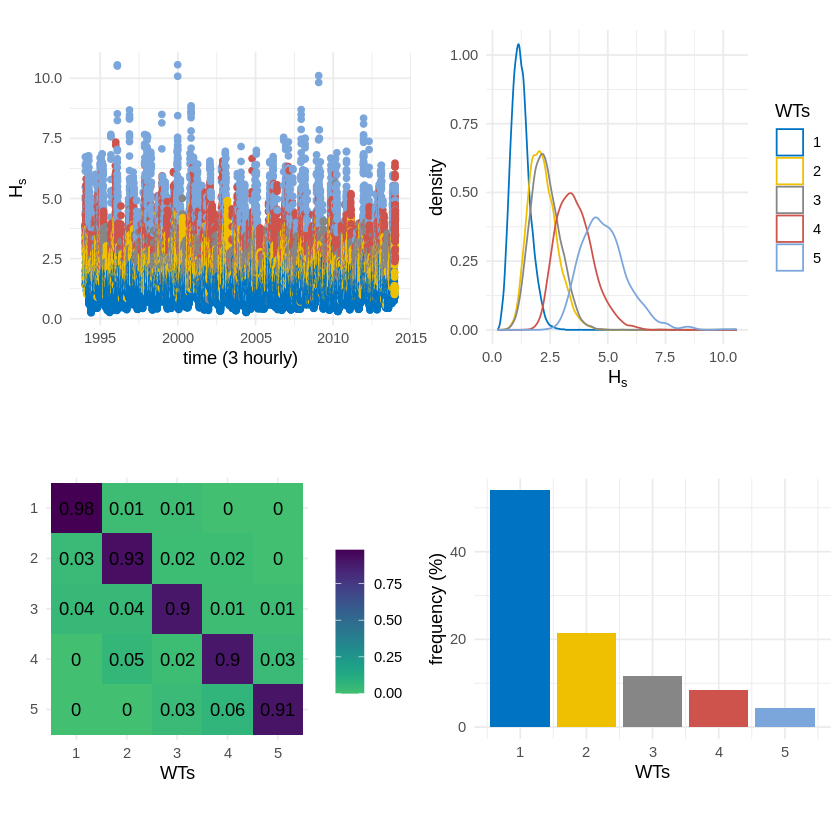

In [51]:
gridExtra::grid.arrange(p3, p4,p2,p1,nrow=2, ncol = 2)

In [52]:
nao = read.table("nao.txt", head = T, sep=",")
nao$year = substring(nao$Date,first = 1, last = 4)
nao$month = substring(nao$Date,first = 5, last = 6)
nao$season = "DJF"
nao$season[nao$month=="03" | nao$month=="04" | nao$month=="05"] = "MAM"
nao$season[nao$month=="06" | nao$month=="07" | nao$month=="08"] = "JJA"
nao$season[nao$month=="09" | nao$month=="10" | nao$month=="11"] = "SNO"
nao_djf = nao[nao$season=="DJF",]
nao_djf = nao_djf %>% group_by(year)%>% summarise(mean(Value))
names(nao_djf) = c("year", "nao")
nao_djf = nao_djf[which(nao_djf$year == 1994):which(nao_djf$year == 2016),]

`summarise()` ungrouping output (override with `.groups` argument)



In [53]:
classes = c(classes_train, classes_test)
dates = c(dates_train, dates_test)

In [54]:
df = as.data.frame.table(table(month(dates),classes)/ rowSums(table(month(dates),classes))*100)
p1 = ggplot(df) + geom_bar(aes(y = Freq, x = Var1, fill = classes),stat="identity")+scale_fill_jco(name="WTs")+ xlab("month")+
ylab("frequency (%)")+ theme_minimal() + theme(aspect.ratio=1)

In [55]:
years = year(dates)
month = month(dates)
months = month(dates)
months[months==12|months==1|months==2] = "DJF"
months[months==3|months==4|months==5] = "MAM"
months[months==6|months==7|months==8] = "JJA"
months[months==9|months==10|months==11] = "SON"
nao_djf = data.frame(nao_djf)
df = as.data.frame.table(table(years[months=="DJF"],classes[months=="DJF"])/ rowSums(table(years[months=="DJF"],classes[months=="DJF"]))*100)
p2 = ggplot(df) + geom_bar(aes(y = Freq, x = Var1, fill = Var2),stat="identity")+scale_fill_jco()+ xlab("year")+
ylab("")+ theme_minimal() + theme(aspect.ratio=0.9, legend.position = 'none')+ scale_x_discrete(breaks = seq(1994, 2016,3))
p2 = p2 + geom_line(data= nao_djf, aes(x = year,y = (nao/0.04)+55, group = 1))+ geom_hline(yintercept=55)

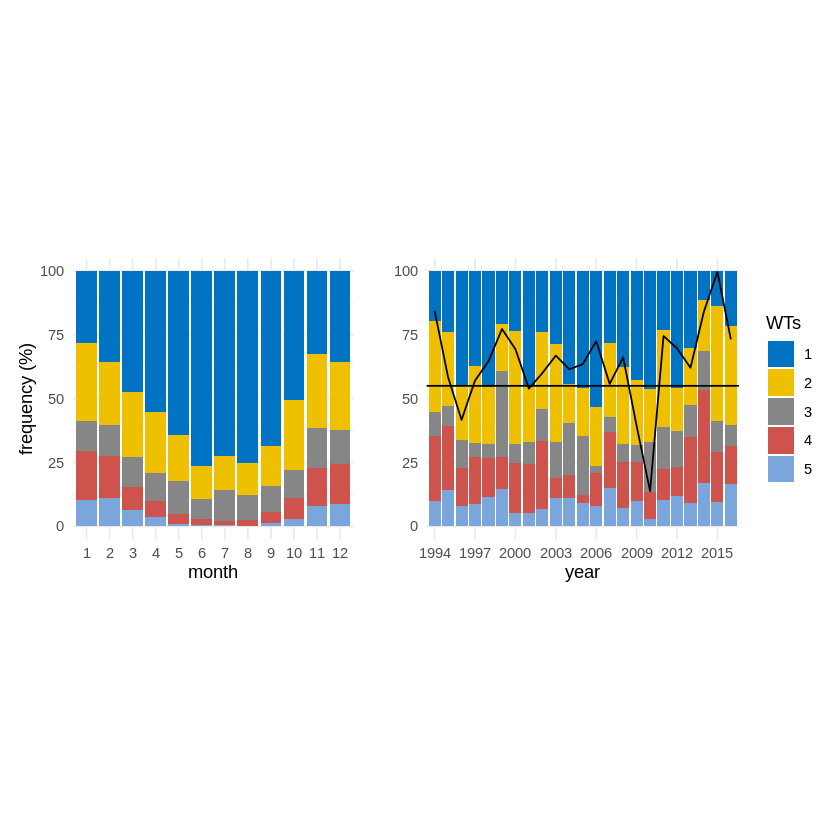

In [56]:
library(patchwork)
p1 + p2 + plot_layout(guides = "collect")

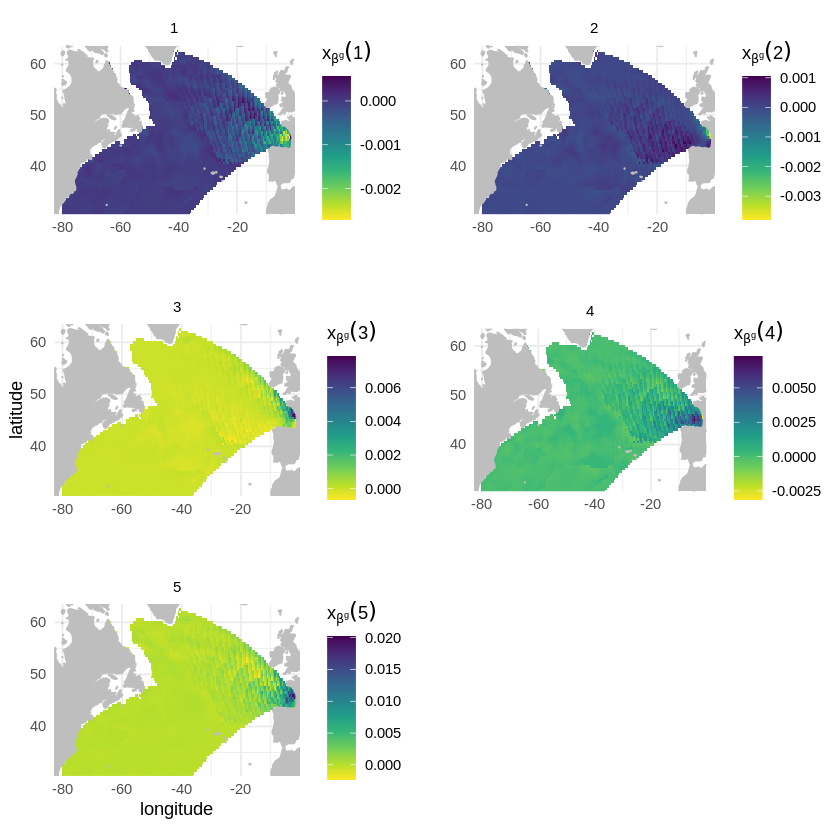

In [57]:
cl = 1:length(unique(km$cluster))
mn = colMeans(xbg)
xb1 = colMeans(xbg[classes_train==cl[1],]) - mn
xb2 = colMeans(xbg[classes_train==cl[2],]) - mn
xb3 = colMeans(xbg[classes_train==cl[3],]) - mn
xb4 = colMeans(xbg[classes_train==cl[4],]) - mn
xb5 = colMeans(xbg[classes_train==cl[5],]) - mn
df1 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xb1, sea = cl[1])
df2 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xb2, sea = cl[2])
df3 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xb3, sea = cl[3])
df4 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xb4, sea = cl[4])
df5 = data.frame(lon = lonlat[,1], lat = lonlat[,2], x = xb5, sea = cl[5])
p1 = ggplot(df1) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(bquote(x[beta^g](1)) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("") + ylab("")+ggtitle("1")+
borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p2 = ggplot(df2) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(bquote(x[beta^g](2)) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5),panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("") + ylab("")+ggtitle("2")+
borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p3 = ggplot(df3) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(bquote(x[beta^g](3)) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("") + ylab("latitude")+ggtitle("3")+
borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p4 = ggplot(df4) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(bquote(x[beta^g](4)) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5),panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("") + ylab("")+ggtitle("4")+
borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
p5 = ggplot(df5) + geom_tile(aes(lon, lat, fill = x))+scale_fill_gradientn(bquote(x[beta^g](5)) ,colours = rev(viridis(10)))+theme_minimal()+
theme(plot.title = element_text(size = 9, hjust = 0.5), panel.spacing = unit(1, "lines"),aspect.ratio=0.7)+ xlab("longitude") + ylab("")+ggtitle("5")+
borders("world", colour="grey",fill= "grey",xlim=c(-80, 0), ylim = c(30, 70))+coord_cartesian(xlim=c(-79, -4), ylim = c(32, 62))
gridExtra::grid.arrange(p1, p2,p3,p4,p5, ncol = 2)

In [58]:
b = WT_reg(g_train, y_train$hs, l_train,classes_train, k, lambda = 1.1e+3)

In [59]:
pred = WT_pred(b,g_test, l_test,classes_test, k)
fitted =  WT_pred(b,g_train, l_train,classes_train, k)

In [60]:
df1 = data.frame(hs = y_test$hs, pred = pred, clu = classes_test)
p1 = ggplot(df1) + geom_point(aes(x = hs,y = pred, col = factor(clu)))+scale_color_jco(name="WTs")+
  geom_abline(slope = 1,intercept = 0)+xlab("observed")+
  ylab("predicted")+
  geom_text(data=tibble(x = 0.4, y = 8.5),aes(x=x , y=y ,label=paste0("r = ",round(cor(df1$hs,df1$pred),digits = 3), "\n","RMSE = ",round(rmse(df1$hs,df1$pred),digits = 3),"\n",
                                                                      "Bias = ",round(bias(df1$hs,df1$pred),digits = 3))
                                                                     , hjust=0))+
  xlim(0.1, max(y_train$hs)) + ylim(0.1, max(y_train$hs)) + theme_minimal()+theme(aspect.ratio=0.9, plot.title = element_text(size = 9, hjust = 0.5))+
  ggtitle("validation period")
df = data.frame(hs = y_train$hs, pred = fitted, clu = classes_train)
p2 = ggplot(df) + geom_point(aes(x = hs,y = pred, col = factor(clu)))+scale_color_jco(name="WTs")+
  geom_abline(slope = 1,intercept = 0)+xlab("observed")+
  ylab("predicted")+
  geom_text(data=tibble(x = 0.4, y = 8.5),aes(x=x , y=y ,label=paste0("r = ",round(cor(df$hs,df$pred),digits = 3), "\n","RMSE = ",round(rmse(df$hs,df$pred),digits = 3),"\n",
                                                                      "Bias = ",round(bias(df$hs,df$pred),digits = 3))
                                                                     , hjust=0))+
  xlim(0.1, max(y_train$hs)) + ylim(0.1, max(y_train$hs)) + theme_minimal()+theme(aspect.ratio=0.9, plot.title = element_text(size = 9, hjust = 0.5))+
  ggtitle("calibration period")
df2 = data.frame(hs = c(y_test$hs,pred), dates = c(dates_test,dates_test), grp = c(rep("observed",length(dates_test)), rep("predicted",length(dates_test))))
p3 = ggplot(df2) + geom_line(aes(x = dates,y = hs, color = grp))+theme_minimal()+scale_color_jco(name = "")  + theme(aspect.ratio=0.7)+
xlab("time (3 hourly)")+ylab(bquote(H[s]))

Warning message:
“Removed 1 rows containing missing values (geom_point).”


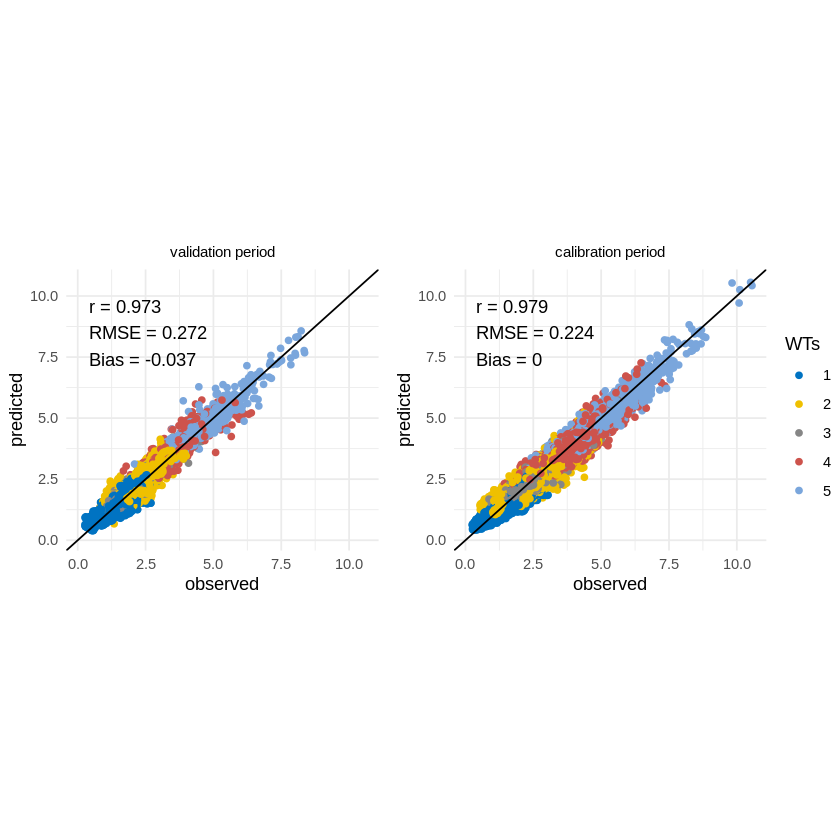

In [62]:
library(gridExtra)
library(grid)
grid_arrange_shared_legend = function(..., nrow = 1, ncol = length(list(...)), position = c("bottom", "right")) {

  plots <- list(...)
  position <- match.arg(position)
  g <- ggplotGrob(plots[[1]] + theme(legend.position = position))$grobs
  legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
  lheight <- sum(legend$height)
  lwidth <- sum(legend$width)
  gl <- lapply(plots, function(x) x + theme(legend.position = "none"))
  gl <- c(gl, nrow = nrow, ncol = ncol)

  combined <- switch(position,
                     "bottom" = arrangeGrob(do.call(arrangeGrob, gl),
                                            legend,
                                            ncol = 1,
                                            heights = unit.c(unit(1, "npc") - lheight, lheight)),
                     "right" = arrangeGrob(do.call(arrangeGrob, gl),
                                           legend,
                                           ncol = 2,
                                           widths = unit.c(unit(1, "npc") - lwidth, lwidth)))
  grid.newpage()
  grid.draw(combined)

}
grid_arrange_shared_legend(p1,p2, ncol = 2, position = "right")

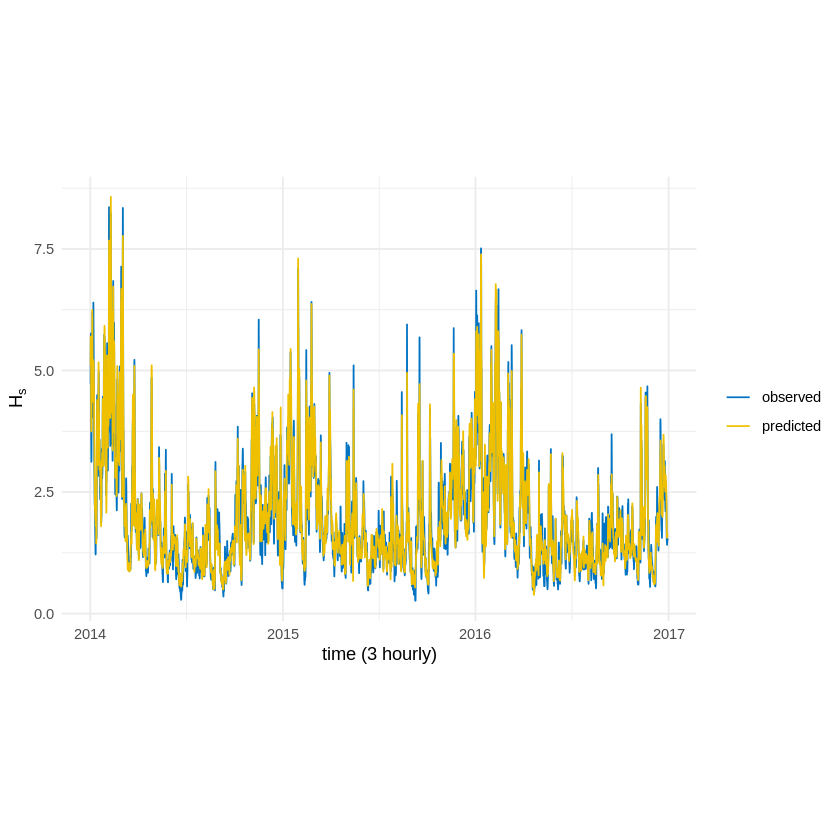

In [63]:
p3

In [64]:
df = data.frame(hs = c(y_test$hs,pred), grp = c(factor(classes_test),factor(classes_test)), col = c(rep("observed",length(pred)), rep("predicted", length(pred))))
p3 = ggplot(df, aes(x=hs)) + geom_histogram(aes(fill=col), alpha = 0.6, position = 'identity')+ theme_minimal()+
facet_wrap(~grp,  ncol=1)+scale_fill_viridis_d("",alpha = 1, begin = 0, end = 0.7)+
theme(aspect.ratio=0.9,strip.text.x = element_blank(), legend.position = c(0.65,.96), plot.margin=unit(c(0.5,-3,0,0), "cm"))
df1 = data.frame(obs = y_test$hs,pred = pred, grp = factor(classes_test))
df2 = data.frame(x = rep(0.4, 5), y = rep(7.5, 5), grp = factor(1:5))
df2$labs = paste0("r = ",round(cor(df1$obs[classes_test==1],df1$pred[classes_test==1]),digits = 3), "\n","RMSE = ",
                  round(rmse(df1$obs[classes_test==1],df1$pred[classes_test==1]),digits = 3),"\n","Bias = ",round(bias(df1$obs[classes_test==1],df1$pred[classes_test==1]),digits = 3))
df2$labs[2] = paste0("r = ",round(cor(df1$obs[classes_test==2],df1$pred[classes_test==2]),digits = 3), "\n","RMSE = ",
                  round(rmse(df1$obs[classes_test==2],df1$pred[classes_test==2]),digits = 3),"\n","Bias = ",round(bias(df1$obs[classes_test==2],df1$pred[classes_test==2]),digits = 3))
df2$labs[3] = paste0("r = ",round(cor(df1$obs[classes_test==3],df1$pred[classes_test==3]),digits = 3), "\n","RMSE = ",
                  round(rmse(df1$obs[classes_test==3],df1$pred[classes_test==3]),digits = 3),"\n","Bias = ",round(bias(df1$obs[classes_test==3],df1$pred[classes_test==3]),digits = 3))
df2$labs[4] = paste0("r = ",round(cor(df1$obs[classes_test==4],df1$pred[classes_test==4]),digits = 3), "\n","RMSE = ",
                  round(rmse(df1$obs[classes_test==4],df1$pred[classes_test==4]),digits = 3),"\n","Bias = ",round(bias(df1$obs[classes_test==4],df1$pred[classes_test==4]),digits = 3))
df2$labs[5] = paste0("r = ",round(cor(df1$obs[classes_test==5],df1$pred[classes_test==5]),digits = 3), "\n","RMSE = ",
                  round(rmse(df1$obs[classes_test==5],df1$pred[classes_test==5]),digits = 3),"\n","Bias = ",round(bias(df1$obs[classes_test==5],df1$pred[classes_test==5]),digits = 3))
p4 = ggplot(df1) + geom_point(aes(x = obs,y = pred))+geom_abline(slope = 1,intercept = 0)+xlab("observed")+ ylab("predicted")+
geom_text(data=df2,aes(x=x , y=y ,label=labs, hjust=0), size = 2.2)+
facet_wrap(~grp,  ncol=1, strip.position="right") + theme_minimal()+theme(aspect.ratio=0.9, plot.margin=unit(c(0.5,0,0,-3), "cm"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



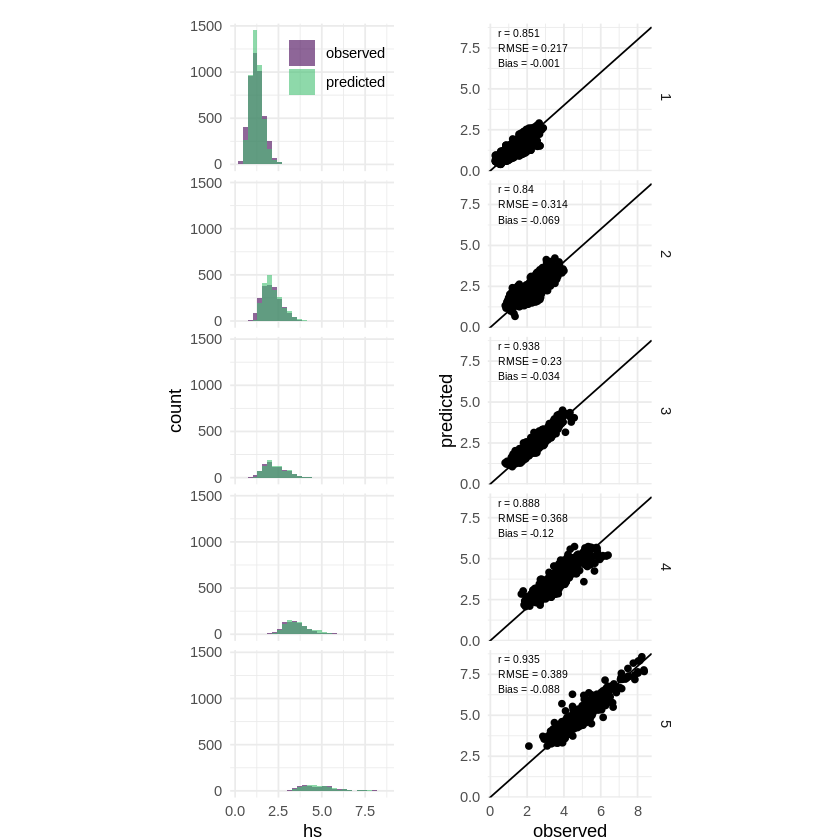

In [65]:
gridExtra::grid.arrange(p3, p4,ncol = 2)